# Funding Rate Intra-Quintile Factor Analysis

Comprehensive analysis of intra-quintile long-short strategies based on funding rate rankings.

## Methodology
- **Factor Signal**: Funding rate percentile ranks 
- **Portfolio**: Within each quintile, long bottom 50% (most negative funding), short top 50% (most positive funding)
- **Rebalancing**: Daily
- **Weighting**: Equal weight within each leg
- **Universe**: Dynamic - all coins with available data each day
- **Strategy**: 5 separate long-short quintile strategies that can be combined

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## 1. Data Loading and Preparation

In [2]:
# Load data
data_loader = BinanceDataLoader(
    data_directory=r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020",
    funding_rate_directory=r"C:\Users\USER\Documents\Binance_related\fundingratedata2022",
    min_records=30,
    min_volume=1e5,
    start_date="2022-01-01",
    end_date=None
)

print("Data loaded successfully!")

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 567 USDT trading pairs
✓ BTCUSDT loaded successfully with 1383 records, avg volume: 347,594
Loaded 530 cryptocurrencies
Filtered 35 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 529 tickers over 1383 dates...
Precomputed returns matrix shape: (1383, 529)
Date range: 2022-01-01 00:00:00 to 2025-10-14 00:00:00
Loading funding rate data from C:\Users\USER\Documents\Binance_related\fundingratedata2022...
Found 567 funding rate files
Loaded funding rates for 529 symbols
Data loaded successfully!


In [3]:
# Get price and funding rate matrices
price = data_loader.get_price_matrix()
funding_rates = data_loader.get_funding_rate_matrix()

print(f"Price matrix shape: {price.shape}")
print(f"Funding rate matrix shape: {funding_rates.shape}")

# Align data - preserve chronological order
common_symbols = list(set(price.columns) & set(funding_rates.columns))
price_dates = set(price.index)
funding_dates = set(funding_rates.index)
common_dates_set = price_dates & funding_dates

# Keep chronological order from price data
common_dates = [date for date in price.index if date in common_dates_set]

print(f"Common symbols: {len(common_symbols)}")
print(f"Common dates: {len(common_dates)}")
print(f"Date range: {common_dates[0]} to {common_dates[-1]}")

# Aligned matrices
price_aligned = price.loc[common_dates, common_symbols].sort_index()
funding_aligned = funding_rates.loc[common_dates, common_symbols].sort_index()

print(f"\nAligned data shapes:")
print(f"Price: {price_aligned.shape}")
print(f"Funding: {funding_aligned.shape}")

Building funding rate matrix with 1383 dates and 529 tickers
Funding rate matrix final shape: (1383, 529)
Price matrix shape: (1383, 529)
Funding rate matrix shape: (1383, 529)
Common symbols: 529
Common dates: 1383
Date range: 2022-01-01 00:00:00 to 2025-10-14 00:00:00

Aligned data shapes:
Price: (1383, 529)
Funding: (1383, 529)


## 2. Factor Construction

In [4]:
# Create factor signals
funding_ranks = funding_aligned.rank(axis=1, pct=True, method='dense')
funding_zscore = funding_aligned.subtract(funding_aligned.mean(axis=1), axis=0).div(funding_aligned.std(axis=1), axis=0)

# Create quintile portfolios
funding_quintiles = pd.DataFrame(index=funding_aligned.index, columns=funding_aligned.columns)
for date in funding_aligned.index:
    day_ranks = funding_ranks.loc[date].dropna()
    if len(day_ranks) >= 5:  # Need at least 5 coins for quintiles
        try:
            quintiles = pd.qcut(day_ranks, 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], duplicates='drop')
            funding_quintiles.loc[date, quintiles.index] = quintiles.values
        except ValueError:
            # Skip days where quintiles can't be created due to insufficient unique values
            continue

print("Factor signals created:")
print(f"- Funding rate ranks: {funding_ranks.shape}")
print(f"- Funding rate z-scores: {funding_zscore.shape}")
print(f"- Quintile portfolios: {funding_quintiles.shape}")

# Summary statistics
print(f"\nFunding rate statistics:")
print(funding_aligned.describe())

Factor signals created:
- Funding rate ranks: (1383, 529)
- Funding rate z-scores: (1383, 529)
- Quintile portfolios: (1383, 529)

Funding rate statistics:
          AGTUSDT    GLMRUSDT  BIGTIMEUSDT     DOGEUSDT    MERLUSDT  \
count  147.000000  633.000000   733.000000  1383.000000  138.000000   
mean     0.000247    0.000132     0.000095     0.000067   -0.000060   
std      0.000354    0.000151     0.000162     0.000118    0.000406   
min     -0.000514   -0.000902    -0.000951    -0.000510   -0.002907   
25%      0.000050    0.000100     0.000050     0.000019    0.000008   
50%      0.000050    0.000100     0.000050     0.000098    0.000050   
75%      0.000375    0.000100     0.000050     0.000100    0.000050   
max      0.002232    0.001226     0.001078     0.000923    0.000527   

         AIOUSDT   SKATEUSDT      FTMUSDT    ORDIUSDT  BROCCOLIF3BUSDT  ...  \
count  62.000000  127.000000  1266.000000  707.000000       208.000000  ...   
mean    0.000352    0.000140     0.000071    0

## 3. Factor Performance Analysis

In [5]:
def calculate_intra_quintile_returns(ranks_df, price_df, quintiles_df):
    """
    Calculate intra-quintile long-short returns for each quintile separately
    Within each quintile: Long bottom 50% funding rates, Short top 50% funding rates
    """
    quintile_returns = {f'Q{i}': [] for i in range(1, 6)}
    portfolio_details = []
    
    for i in range(len(ranks_df) - 1):
        date = ranks_df.index[i]
        next_date = ranks_df.index[i + 1]
        
        # Get quintile assignments for today
        day_quintiles = quintiles_df.loc[date].dropna()
        day_funding = ranks_df.iloc[i].dropna()
        
        if len(day_quintiles) < 10:  # Need minimum coins
            for q in range(1, 6):
                quintile_returns[f'Q{q}'].append(np.nan)
            continue
        
        # Calculate returns for each quintile as intra-quintile long-short
        quintile_details = {'date': date}
        
        for q in range(1, 6):
            quintile_name = f'Q{q}'
            quintile_coins = day_quintiles[day_quintiles == quintile_name].index
            
            if len(quintile_coins) < 4:  # Need at least 4 coins for intra-quintile long-short
                quintile_returns[quintile_name].append(np.nan)
                quintile_details[f'{quintile_name}_long_coins'] = 0
                quintile_details[f'{quintile_name}_short_coins'] = 0
                quintile_details[f'{quintile_name}_return'] = np.nan
                continue
            
            # Get funding rates for coins in this quintile and sort them
            quintile_funding = day_funding[quintile_coins].sort_values()
            
            # Split into exactly 50/50 (or as close as possible)
            quintile_size = len(quintile_coins)
            long_size = quintile_size // 2
            short_size = quintile_size - long_size
            
            # Bottom 50% (most negative funding rates) = LONG
            long_coins = quintile_funding.iloc[:long_size].index
            # Top 50% (most positive funding rates) = SHORT  
            short_coins = quintile_funding.iloc[long_size:].index
            
            if len(long_coins) == 0 or len(short_coins) == 0:
                quintile_returns[quintile_name].append(np.nan)
                quintile_details[f'{quintile_name}_long_coins'] = len(long_coins)
                quintile_details[f'{quintile_name}_short_coins'] = len(short_coins)
                quintile_details[f'{quintile_name}_return'] = np.nan
                continue
            
            # Calculate returns for long and short positions
            long_returns = []
            short_returns = []
            
            for coin in long_coins:
                if coin in price_df.columns:
                    p0 = price_df.loc[date, coin]
                    p1 = price_df.loc[next_date, coin]
                    if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                        long_returns.append((p1 - p0) / p0)
            
            for coin in short_coins:
                if coin in price_df.columns:
                    p0 = price_df.loc[date, coin]
                    p1 = price_df.loc[next_date, coin]
                    if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                        short_returns.append((p1 - p0) / p0)
            
            # Calculate quintile return as long-short
            if len(long_returns) > 0 and len(short_returns) > 0:
                long_return = np.mean(long_returns)
                short_return = np.mean(short_returns)
                quintile_return = long_return - short_return - 0.0005  # 5bps transaction costs
                
                quintile_returns[quintile_name].append(quintile_return)
                quintile_details[f'{quintile_name}_long_coins'] = len(long_returns)
                quintile_details[f'{quintile_name}_short_coins'] = len(short_returns)
                quintile_details[f'{quintile_name}_return'] = quintile_return
            else:
                quintile_returns[quintile_name].append(np.nan)
                quintile_details[f'{quintile_name}_long_coins'] = len(long_returns)
                quintile_details[f'{quintile_name}_short_coins'] = len(short_returns)
                quintile_details[f'{quintile_name}_return'] = np.nan
        
        portfolio_details.append(quintile_details)
    
    # Convert to DataFrames
    quintile_df = pd.DataFrame(quintile_returns, index=ranks_df.index[:-1])
    details_df = pd.DataFrame(portfolio_details).set_index('date')
    
    return quintile_df, details_df

def calculate_intra_quintile_factor_returns(ranks_df, price_df, long_pct=0.2, short_pct=0.2):
    """
    Alternative method: Calculate intra-quintile returns using percentile thresholds
    """
    quintile_returns = {f'Q{i}': [] for i in range(1, 6)}
    portfolio_details = []
    
    for i in range(len(ranks_df) - 1):
        date = ranks_df.index[i]
        next_date = ranks_df.index[i + 1]
        
        # Get ranks for today
        day_ranks = ranks_df.iloc[i].dropna()
        
        if len(day_ranks) < 10:  # Need minimum coins
            for q in range(1, 6):
                quintile_returns[f'Q{q}'].append(np.nan)
            continue
        
        # Define quintile breakpoints
        breakpoints = [day_ranks.quantile(i/5) for i in range(6)]
        
        quintile_details = {'date': date}
        
        for q in range(1, 6):
            # Get coins in this quintile
            if q == 1:
                quintile_coins = day_ranks[day_ranks <= breakpoints[1]].index
            elif q == 5:
                quintile_coins = day_ranks[day_ranks > breakpoints[4]].index
            else:
                quintile_coins = day_ranks[(day_ranks > breakpoints[q-1]) & (day_ranks <= breakpoints[q])].index
            
            quintile_name = f'Q{q}'
            
            if len(quintile_coins) < 4:  # Need at least 4 coins for intra-quintile long-short
                quintile_returns[quintile_name].append(np.nan)
                quintile_details[f'{quintile_name}_long_coins'] = 0
                quintile_details[f'{quintile_name}_short_coins'] = 0
                quintile_details[f'{quintile_name}_return'] = np.nan
                continue
            
            # Sort quintile coins by funding rate for exact 50/50 split
            quintile_funding = day_ranks[quintile_coins].sort_values()
            
            # Split into exactly 50/50 (or as close as possible)
            quintile_size = len(quintile_coins)
            long_size = quintile_size // 2
            short_size = quintile_size - long_size
            
            # Bottom 50% (most negative funding rates) = LONG
            long_coins = quintile_funding.iloc[:long_size].index
            # Top 50% (most positive funding rates) = SHORT
            short_coins = quintile_funding.iloc[long_size:].index
            
            if len(long_coins) == 0 or len(short_coins) == 0:
                quintile_returns[quintile_name].append(np.nan)
                quintile_details[f'{quintile_name}_long_coins'] = len(long_coins)
                quintile_details[f'{quintile_name}_short_coins'] = len(short_coins)
                quintile_details[f'{quintile_name}_return'] = np.nan
                continue
            
            # Calculate returns for long and short positions
            long_returns = []
            short_returns = []
            
            for coin in long_coins:
                if coin in price_df.columns:
                    p0 = price_df.loc[date, coin]
                    p1 = price_df.loc[next_date, coin]
                    if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                        long_returns.append((p1 - p0) / p0)
            
            for coin in short_coins:
                if coin in price_df.columns:
                    p0 = price_df.loc[date, coin]
                    p1 = price_df.loc[next_date, coin]
                    if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                        short_returns.append((p1 - p0) / p0)
            
            # Calculate quintile return as long-short
            if len(long_returns) > 0 and len(short_returns) > 0:
                long_return = np.mean(long_returns)
                short_return = np.mean(short_returns)
                quintile_return = long_return - short_return - 0.0005  # 5bps transaction costs
                
                quintile_returns[quintile_name].append(quintile_return)
                quintile_details[f'{quintile_name}_long_coins'] = len(long_returns)
                quintile_details[f'{quintile_name}_short_coins'] = len(short_returns)
                quintile_details[f'{quintile_name}_return'] = quintile_return
            else:
                quintile_returns[quintile_name].append(np.nan)
                quintile_details[f'{quintile_name}_long_coins'] = len(long_returns)
                quintile_details[f'{quintile_name}_short_coins'] = len(short_returns)
                quintile_details[f'{quintile_name}_return'] = np.nan
        
        portfolio_details.append(quintile_details)
    
    # Convert to DataFrames
    quintile_df = pd.DataFrame(quintile_returns, index=ranks_df.index[:-1])
    details_df = pd.DataFrame(portfolio_details).set_index('date')
    
    return quintile_df, details_df

# Calculate intra-quintile returns using both methods
print("Calculating intra-quintile long-short returns...")

# Method 1: Using pre-computed quintiles (may have missing days)
try:
    quintile_returns_1, portfolio_details_1 = calculate_intra_quintile_returns(
        funding_ranks, price_aligned, funding_quintiles)
    print("Method 1 (pre-computed quintiles) completed")
except Exception as e:
    print(f"Method 1 failed: {e}")
    quintile_returns_1 = None

# Method 2: Using percentile breakpoints (more robust)
quintile_returns_2, portfolio_details_2 = calculate_intra_quintile_factor_returns(
    funding_ranks, price_aligned)
print("Method 2 (percentile breakpoints) completed")

# Use the more robust method
quintile_returns = quintile_returns_2
portfolio_details = portfolio_details_2

# Calculate combined portfolio (equal weight of all quintiles)
combined_portfolio = quintile_returns.mean(axis=1)

print(f"\nIntra-Quintile Returns Summary:")
print(f"Data points: {len(quintile_returns)}")
print(f"\nIndividual quintile statistics (annualized):")

for q in range(1, 6):
    q_name = f'Q{q}'
    q_clean = quintile_returns[q_name].dropna()
    if len(q_clean) > 0:
        q_annual_ret = q_clean.mean() * 365
        q_annual_vol = q_clean.std() * np.sqrt(365)
        q_sharpe = q_annual_ret / q_annual_vol if q_annual_vol != 0 else 0
        valid_days = q_clean.notna().sum()
        print(f"{q_name}: Return={q_annual_ret:.2%}, Vol={q_annual_vol:.2%}, Sharpe={q_sharpe:.3f}, Valid Days={valid_days}")

# Combined portfolio statistics
combined_clean = combined_portfolio.dropna()
if len(combined_clean) > 0:
    combined_annual_ret = combined_clean.mean() * 365
    combined_annual_vol = combined_clean.std() * np.sqrt(365)
    combined_sharpe = combined_annual_ret / combined_annual_vol if combined_annual_vol != 0 else 0
    print(f"\nCombined Portfolio: Return={combined_annual_ret:.2%}, Vol={combined_annual_vol:.2%}, Sharpe={combined_sharpe:.3f}")

print(f"\nPortfolio details (average long/short coins per quintile):")
long_short_cols = [col for col in portfolio_details.columns if 'long_coins' in col or 'short_coins' in col]
if long_short_cols:
    print(portfolio_details[long_short_cols].describe())

# Verify 50/50 splits
print(f"\n=== VERIFYING 50/50 SPLITS ===")
for q in range(1, 6):
    long_col = f'Q{q}_long_coins'
    short_col = f'Q{q}_short_coins'
    if long_col in portfolio_details.columns and short_col in portfolio_details.columns:
        avg_long = portfolio_details[long_col].mean()
        avg_short = portfolio_details[short_col].mean()
        total_avg = avg_long + avg_short
        long_pct = avg_long / total_avg * 100 if total_avg > 0 else 0
        short_pct = avg_short / total_avg * 100 if total_avg > 0 else 0
        print(f"Q{q}: {avg_long:.1f} long ({long_pct:.1f}%) vs {avg_short:.1f} short ({short_pct:.1f}%)")

Calculating intra-quintile long-short returns...
Method 1 (pre-computed quintiles) completed
Method 2 (percentile breakpoints) completed

Intra-Quintile Returns Summary:
Data points: 1382

Individual quintile statistics (annualized):
Q1: Return=-27.70%, Vol=29.47%, Sharpe=-0.940, Valid Days=1382
Q2: Return=-30.66%, Vol=21.98%, Sharpe=-1.395, Valid Days=987
Q3: Return=-24.07%, Vol=36.70%, Sharpe=-0.656, Valid Days=749
Q4: Return=-8.17%, Vol=22.89%, Sharpe=-0.357, Valid Days=635
Q5: Return=-87.50%, Vol=86.69%, Sharpe=-1.009, Valid Days=627

Combined Portfolio: Return=-39.30%, Vol=22.09%, Sharpe=-1.779

Portfolio details (average long/short coins per quintile):
       Q1_long_coins  Q1_short_coins  Q2_long_coins  Q2_short_coins  \
count    1382.000000     1382.000000    1382.000000     1382.000000   
mean       42.314761       42.872648      31.601302       31.970333   
std        36.152306       36.014757      34.608343       34.590558   
min        10.000000       10.000000       0.0000

=== INTRA-QUINTILE FACTOR PERFORMANCE ===

Q1 (Intra-Quintile Long-Short):
Annual Return: -27.70%
Annual Volatility: 29.47%
Sharpe Ratio: -0.940
Maximum Drawdown: -105.39%
Hit Rate: 46.24%

Q2 (Intra-Quintile Long-Short):
Annual Return: -30.66%
Annual Volatility: 21.98%
Sharpe Ratio: -1.395
Maximum Drawdown: -92.85%
Hit Rate: 46.81%

Q3 (Intra-Quintile Long-Short):
Annual Return: -24.07%
Annual Volatility: 36.70%
Sharpe Ratio: -0.656
Maximum Drawdown: -79.91%
Hit Rate: 50.20%

Q4 (Intra-Quintile Long-Short):
Annual Return: -8.17%
Annual Volatility: 22.89%
Sharpe Ratio: -0.357
Maximum Drawdown: -32.18%
Hit Rate: 47.72%

Q5 (Intra-Quintile Long-Short):
Annual Return: -87.50%
Annual Volatility: 86.69%
Sharpe Ratio: -1.009
Maximum Drawdown: -174.01%
Hit Rate: 48.17%

COMBINED PORTFOLIO (Equal-Weight All Quintiles):
Annual Return: -39.30%
Annual Volatility: 22.09%
Sharpe Ratio: -1.779
Maximum Drawdown: -149.59%
Hit Rate: 45.37%

Quintile Strategy Correlations:
       Q1     Q2     Q3     Q4

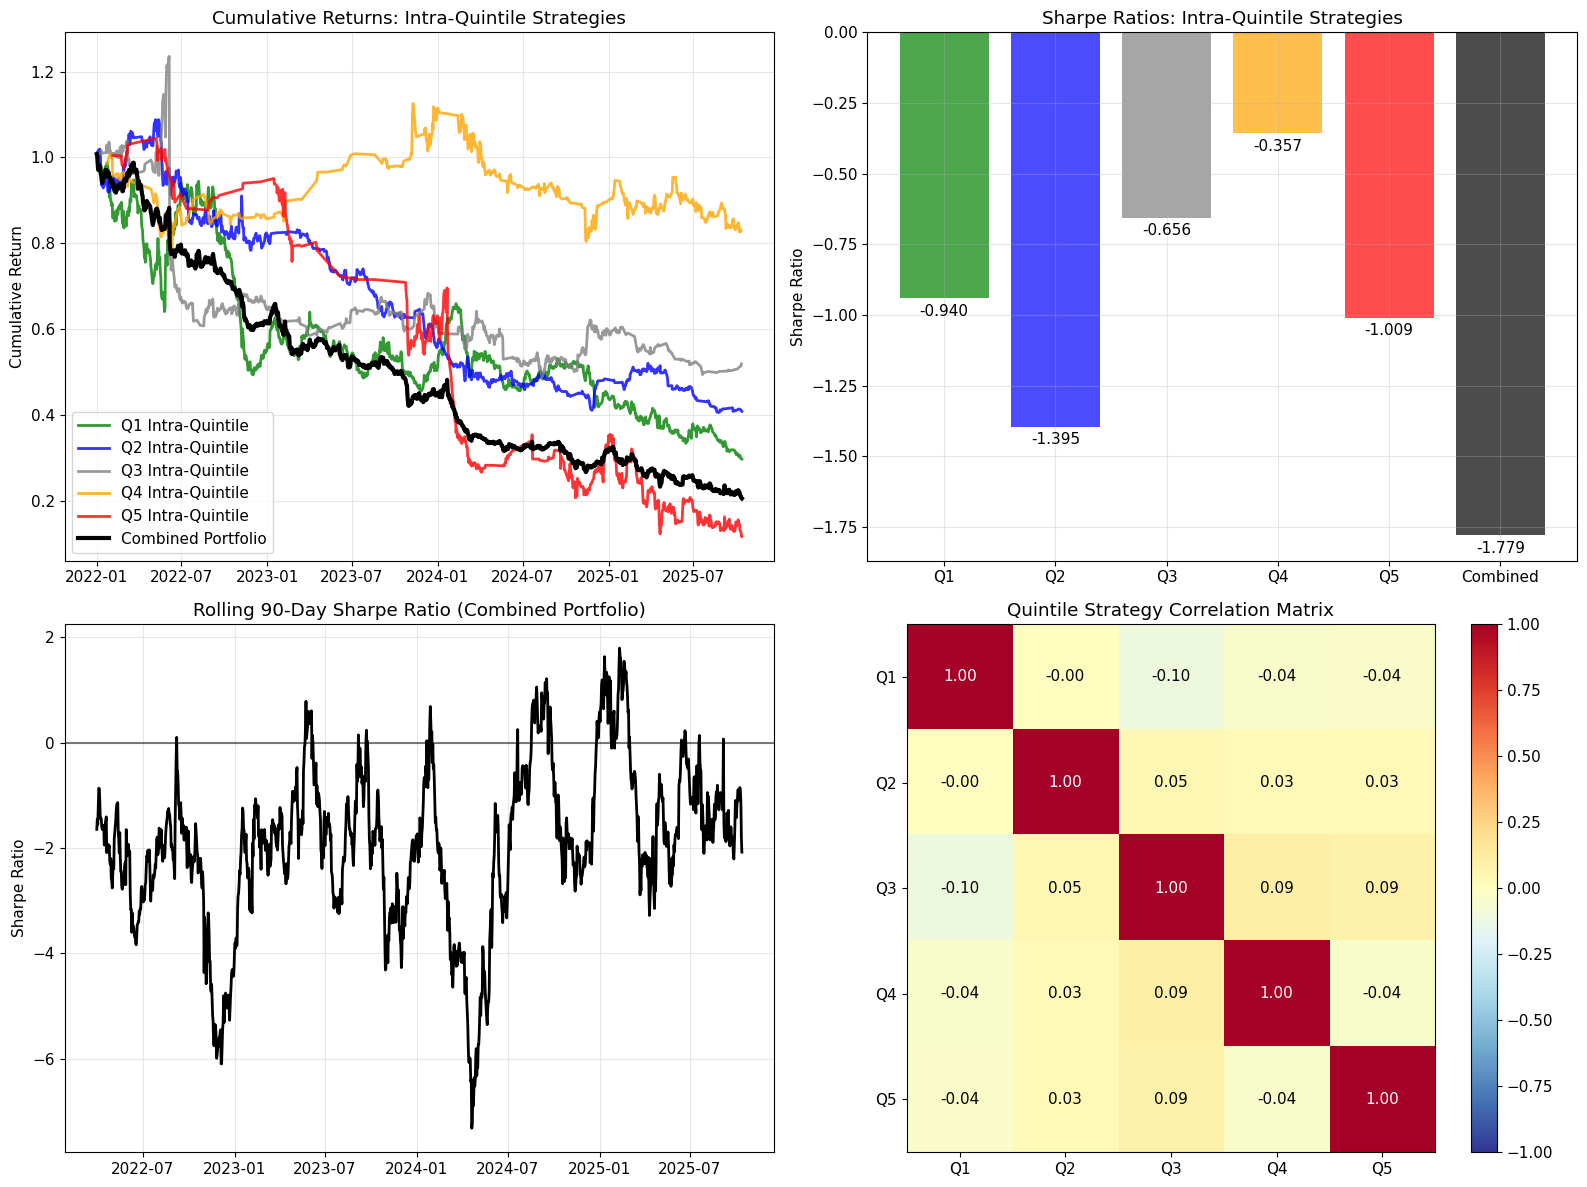


=== QUINTILE PERFORMANCE COMPARISON ===
Strategy        Annual Ret   Annual Vol   Sharpe     Max DD     Hit Rate  
--------------------------------------------------------------------------------
Q1              -27.70%      29.47%       -0.940     -105.39%   46.24%    
Q2              -30.66%      21.98%       -1.395     -92.85%    46.81%    
Q3              -24.07%      36.70%       -0.656     -79.91%    50.20%    
Q4              -8.17%       22.89%       -0.357     -32.18%    47.72%    
Q5              -87.50%      86.69%       -1.009     -174.01%   48.17%    
Combined        -39.30%      22.09%       -1.779     -149.59%   45.37%    

=== DIVERSIFICATION ANALYSIS ===
Average Individual Quintile Volatility: 46.34%
Combined Portfolio Volatility: 22.09%
Diversification Ratio: 2.10
Volatility Reduction: 52.3%


In [6]:
# Performance metrics for individual quintiles and combined portfolio
print("=== INTRA-QUINTILE FACTOR PERFORMANCE ===")

# Calculate metrics for each quintile
quintile_metrics = {}
for q in range(1, 6):
    q_name = f'Q{q}'
    q_clean = quintile_returns[q_name].dropna()
    
    if len(q_clean) > 0:
        annual_return = q_clean.mean() * 365
        annual_vol = q_clean.std() * np.sqrt(365)
        sharpe_ratio = annual_return / annual_vol if annual_vol != 0 else 0
        max_dd = (q_clean.cumsum() - q_clean.cumsum().cummax()).min()
        hit_rate = (q_clean > 0).mean()
        skewness = q_clean.skew()
        kurtosis = q_clean.kurtosis()
        
        quintile_metrics[q_name] = {
            'annual_return': annual_return,
            'annual_vol': annual_vol,
            'sharpe_ratio': sharpe_ratio,
            'max_dd': max_dd,
            'hit_rate': hit_rate,
            'skewness': skewness,
            'kurtosis': kurtosis
        }
        
        print(f"\n{q_name} (Intra-Quintile Long-Short):")
        print(f"Annual Return: {annual_return:.2%}")
        print(f"Annual Volatility: {annual_vol:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
        print(f"Maximum Drawdown: {max_dd:.2%}")
        print(f"Hit Rate: {hit_rate:.2%}")

# Combined portfolio metrics
combined_clean = combined_portfolio.dropna()
combined_annual_ret = combined_clean.mean() * 365
combined_annual_vol = combined_clean.std() * np.sqrt(365)
combined_sharpe = combined_annual_ret / combined_annual_vol if combined_annual_vol != 0 else 0
combined_max_dd = (combined_clean.cumsum() - combined_clean.cumsum().cummax()).min()
combined_hit_rate = (combined_clean > 0).mean()

print(f"\nCOMBINED PORTFOLIO (Equal-Weight All Quintiles):")
print(f"Annual Return: {combined_annual_ret:.2%}")
print(f"Annual Volatility: {combined_annual_vol:.2%}")
print(f"Sharpe Ratio: {combined_sharpe:.3f}")
print(f"Maximum Drawdown: {combined_max_dd:.2%}")
print(f"Hit Rate: {combined_hit_rate:.2%}")

# Calculate correlations between quintile strategies
quintile_corr = quintile_returns.corr()
print(f"\nQuintile Strategy Correlations:")
print(quintile_corr.round(3))

# Cumulative returns for plotting
quintile_cumulative = {}
for q in range(1, 6):
    q_name = f'Q{q}'
    q_clean = quintile_returns[q_name].dropna()
    if len(q_clean) > 0:
        quintile_cumulative[q_name] = (1 + q_clean).cumprod()

combined_cumulative = (1 + combined_clean).cumprod()

# Plot performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Cumulative returns - All quintile strategies + combined
colors = ['green', 'blue', 'gray', 'orange', 'red']
for i, (q_name, q_cum) in enumerate(quintile_cumulative.items()):
    axes[0,0].plot(q_cum.index, q_cum.values, linewidth=2, color=colors[i], alpha=0.8, label=f'{q_name} Intra-Quintile')

axes[0,0].plot(combined_cumulative.index, combined_cumulative.values, linewidth=3, color='black', label='Combined Portfolio')
axes[0,0].set_title('Cumulative Returns: Intra-Quintile Strategies')
axes[0,0].set_ylabel('Cumulative Return')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Sharpe ratio comparison
sharpe_ratios = [quintile_metrics[f'Q{q}']['sharpe_ratio'] for q in range(1, 6) if f'Q{q}' in quintile_metrics]
quintile_names = [f'Q{q}' for q in range(1, 6) if f'Q{q}' in quintile_metrics]
quintile_names.append('Combined')
sharpe_ratios.append(combined_sharpe)

bars = axes[0,1].bar(quintile_names, sharpe_ratios, 
                    color=colors + ['black'], alpha=0.7)
axes[0,1].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0,1].set_title('Sharpe Ratios: Intra-Quintile Strategies')
axes[0,1].set_ylabel('Sharpe Ratio')
axes[0,1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, sharpe in zip(bars, sharpe_ratios):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.02),
                  f'{sharpe:.3f}', ha='center', va='bottom' if height >= 0 else 'top')

# Rolling Sharpe ratio for combined portfolio (90-day)
rolling_sharpe_combined = combined_clean.rolling(90).apply(lambda x: (x.mean() * 365) / (x.std() * np.sqrt(365)))
axes[1,0].plot(rolling_sharpe_combined.index, rolling_sharpe_combined.values, linewidth=2, color='black')
axes[1,0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,0].set_title('Rolling 90-Day Sharpe Ratio (Combined Portfolio)')
axes[1,0].set_ylabel('Sharpe Ratio')
axes[1,0].grid(True, alpha=0.3)

# Correlation heatmap
im = axes[1,1].imshow(quintile_corr.values, cmap='RdYlBu_r', vmin=-1, vmax=1)
axes[1,1].set_xticks(range(len(quintile_corr.columns)))
axes[1,1].set_yticks(range(len(quintile_corr.columns)))
axes[1,1].set_xticklabels(quintile_corr.columns)
axes[1,1].set_yticklabels(quintile_corr.columns)
axes[1,1].set_title('Quintile Strategy Correlation Matrix')

# Add correlation values to heatmap
for i in range(len(quintile_corr.columns)):
    for j in range(len(quintile_corr.columns)):
        text = axes[1,1].text(j, i, f'{quintile_corr.iloc[i, j]:.2f}',
                             ha="center", va="center", color="black" if abs(quintile_corr.iloc[i, j]) < 0.5 else "white")

plt.colorbar(im, ax=axes[1,1])
plt.tight_layout()
plt.show()

# Quintile performance table
print(f"\n=== QUINTILE PERFORMANCE COMPARISON ===")
print(f"{'Strategy':<15} {'Annual Ret':<12} {'Annual Vol':<12} {'Sharpe':<10} {'Max DD':<10} {'Hit Rate':<10}")
print("-" * 80)

for q in range(1, 6):
    q_name = f'Q{q}'
    if q_name in quintile_metrics:
        metrics = quintile_metrics[q_name]
        print(f"{q_name:<15} {metrics['annual_return']:<12.2%} {metrics['annual_vol']:<12.2%} {metrics['sharpe_ratio']:<10.3f} {metrics['max_dd']:<10.2%} {metrics['hit_rate']:<10.2%}")

print(f"{'Combined':<15} {combined_annual_ret:<12.2%} {combined_annual_vol:<12.2%} {combined_sharpe:<10.3f} {combined_max_dd:<10.2%} {combined_hit_rate:<10.2%}")

# Diversification benefit analysis
equal_weight_vol = np.sqrt(sum([quintile_metrics[f'Q{q}']['annual_vol']**2 for q in range(1, 6) if f'Q{q}' in quintile_metrics]) / 5)
diversification_ratio = equal_weight_vol / combined_annual_vol if combined_annual_vol != 0 else 0

print(f"\n=== DIVERSIFICATION ANALYSIS ===")
print(f"Average Individual Quintile Volatility: {equal_weight_vol:.2%}")
print(f"Combined Portfolio Volatility: {combined_annual_vol:.2%}")
print(f"Diversification Ratio: {diversification_ratio:.2f}")
print(f"Volatility Reduction: {(1 - combined_annual_vol/equal_weight_vol)*100:.1f}%")

## 4. Information Coefficient (IC) Analysis

Information Coefficient Analysis by Quintile

Q1 Quintile:
IC Mean: 0.0372
IC Std: 0.1688
IC Information Ratio: 0.220
IC Hit Rate: 59.09%
IC t-statistic: 3.264
Observations: 220

Q2 Quintile:
IC Mean: -0.0047
IC Std: 0.1617
IC Information Ratio: -0.029
IC Hit Rate: 43.58%
IC t-statistic: -0.430
Observations: 218

Q3 Quintile:
IC Mean: -0.0182
IC Std: 0.1873
IC Information Ratio: -0.097
IC Hit Rate: 46.89%
IC t-statistic: -1.403
Observations: 209

Q4 Quintile:
IC Mean: -0.0247
IC Std: 0.1803
IC Information Ratio: -0.137
IC Hit Rate: 41.83%
IC t-statistic: -1.978
Observations: 208

Q5 Quintile:
IC Mean: -0.0128
IC Std: 0.1864
IC Information Ratio: -0.069
IC Hit Rate: 51.22%
IC t-statistic: -0.881
Observations: 164


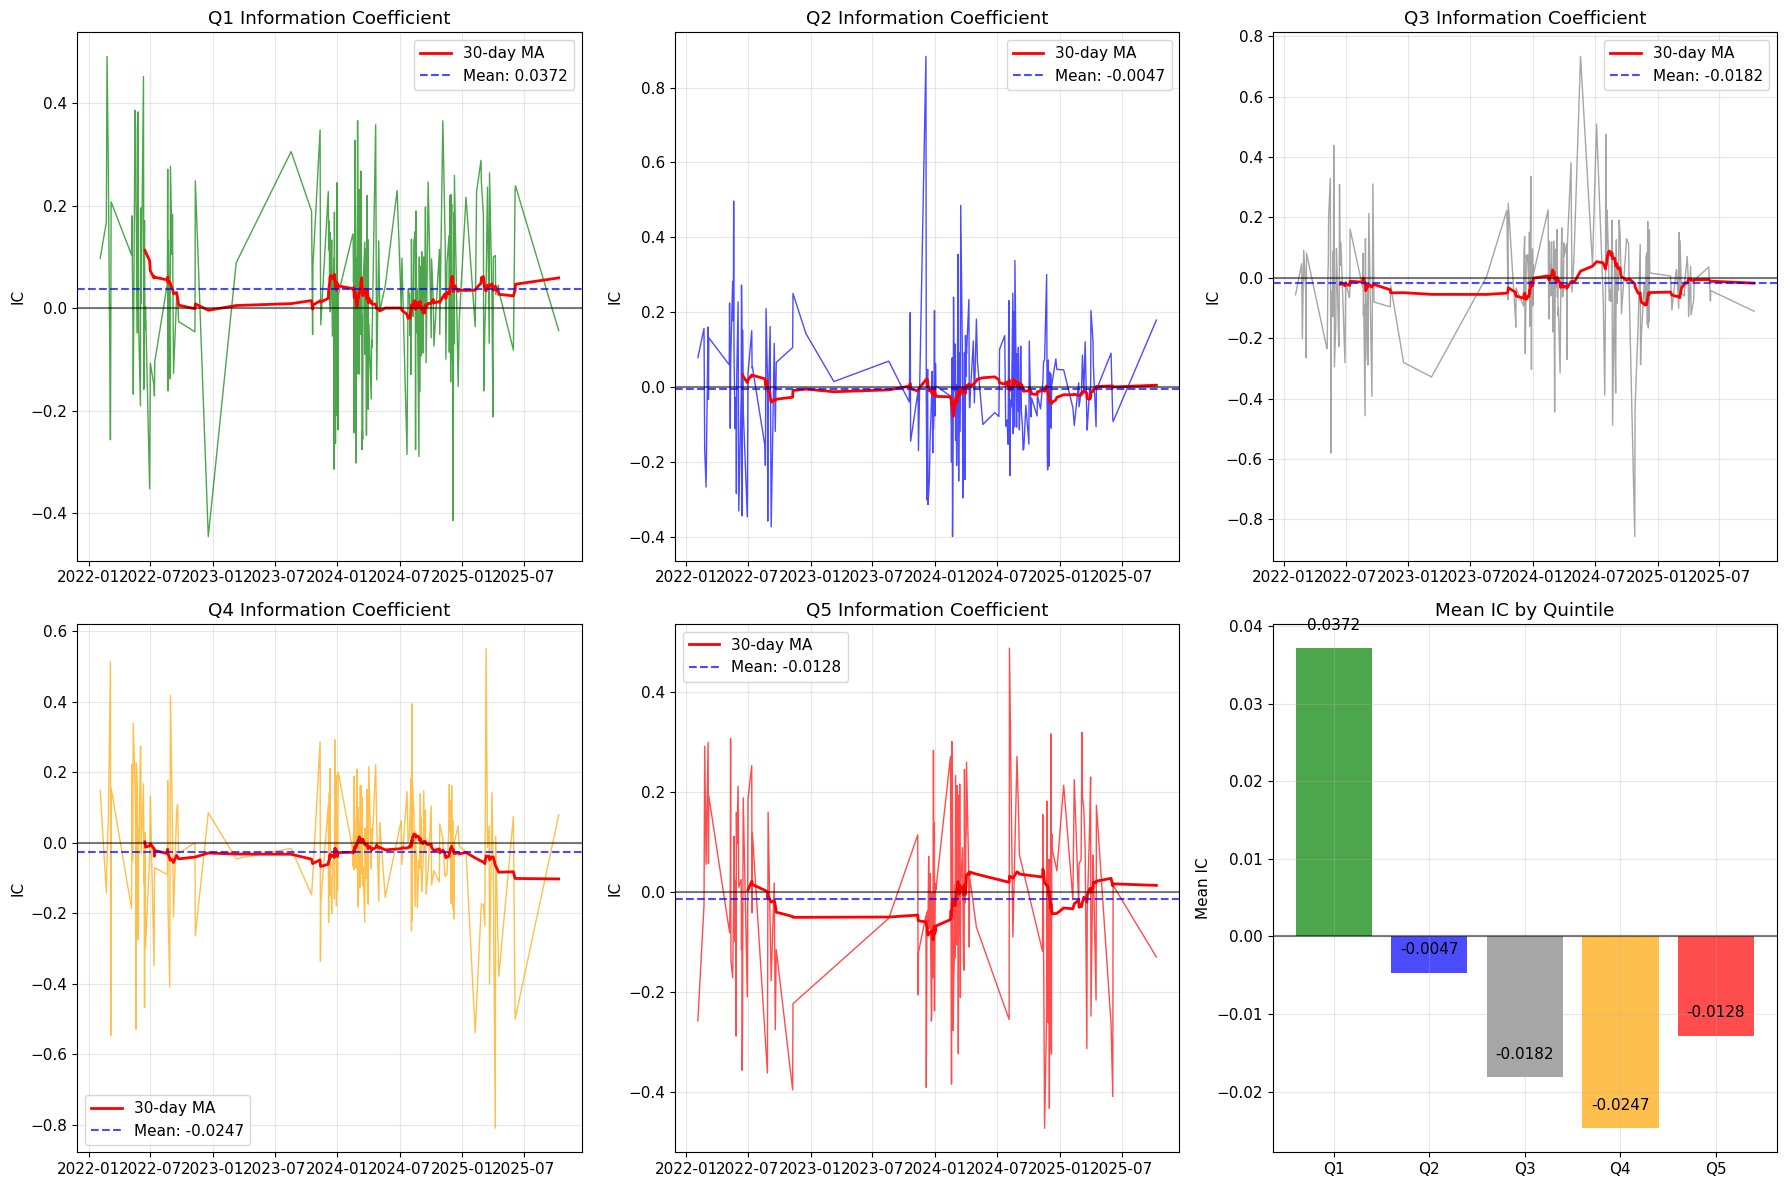


=== IC SUMMARY BY QUINTILE ===
Quintile   Mean IC    IC IR      Hit Rate     t-stat     N Obs     
----------------------------------------------------------------------
Q1         0.0372     0.220      59.09%       3.264      220       
Q2         -0.0047    -0.029     43.58%       -0.430     218       
Q3         -0.0182    -0.097     46.89%       -1.403     209       
Q4         -0.0247    -0.137     41.83%       -1.978     208       
Q5         -0.0128    -0.069     51.22%       -0.881     164       

COMBINED IC (All Quintiles):
Mean IC: -0.0038
IC Information Ratio: -0.022
IC Hit Rate: 48.48%
IC t-statistic: -0.687
Total Observations: 1019


In [7]:
def calculate_ic_for_quintiles(factor_ranks, forward_returns, quintiles_df):
    """
    Calculate Information Coefficient for each quintile separately
    """
    quintile_ic = {f'Q{i}': [] for i in range(1, 6)}
    
    for i in range(len(factor_ranks) - 1):
        date = factor_ranks.index[i]
        next_date = factor_ranks.index[i + 1]
        
        factor_today = factor_ranks.iloc[i].dropna()
        returns_tomorrow = forward_returns.iloc[i + 1].dropna()
        day_quintiles = quintiles_df.loc[date].dropna()
        
        for q in range(1, 6):
            q_name = f'Q{q}'
            quintile_coins = day_quintiles[day_quintiles == q_name].index
            
            # Get common coins in this quintile
            common_coins = factor_today.index.intersection(returns_tomorrow.index).intersection(quintile_coins)
            
            if len(common_coins) < 5:  # Skip if too few coins in quintile
                quintile_ic[q_name].append({'date': date, 'ic': np.nan})
                continue
            
            # Calculate Spearman rank correlation within quintile
            try:
                ic = factor_today[common_coins].corr(returns_tomorrow[common_coins], method='spearman')
                quintile_ic[q_name].append({'date': date, 'ic': ic})
            except:
                quintile_ic[q_name].append({'date': date, 'ic': np.nan})
    
    # Convert to DataFrames
    quintile_ic_dfs = {}
    for q_name in quintile_ic:
        quintile_ic_dfs[q_name] = pd.DataFrame(quintile_ic[q_name]).set_index('date')
    
    return quintile_ic_dfs

# Calculate forward returns
forward_returns_1d = price_aligned.pct_change()

# Calculate ICs for each quintile
quintile_ics = calculate_ic_for_quintiles(funding_ranks, forward_returns_1d, funding_quintiles)

print("Information Coefficient Analysis by Quintile")
print("=" * 50)

# Calculate IC statistics for each quintile
ic_summary = {}
for q in range(1, 6):
    q_name = f'Q{q}'
    ic_clean = quintile_ics[q_name]['ic'].dropna()
    
    if len(ic_clean) > 10:  # Need sufficient data points
        ic_mean = ic_clean.mean()
        ic_std = ic_clean.std()
        ic_ir = ic_mean / ic_std if ic_std != 0 else 0
        ic_hit_rate = (ic_clean > 0).mean()
        ic_tstat = ic_mean / (ic_std / np.sqrt(len(ic_clean))) if ic_std != 0 else 0
        
        ic_summary[q_name] = {
            'mean': ic_mean,
            'std': ic_std,
            'ir': ic_ir,
            'hit_rate': ic_hit_rate,
            'tstat': ic_tstat,
            'n_obs': len(ic_clean)
        }
        
        print(f"\n{q_name} Quintile:")
        print(f"IC Mean: {ic_mean:.4f}")
        print(f"IC Std: {ic_std:.4f}")
        print(f"IC Information Ratio: {ic_ir:.3f}")
        print(f"IC Hit Rate: {ic_hit_rate:.2%}")
        print(f"IC t-statistic: {ic_tstat:.3f}")
        print(f"Observations: {len(ic_clean)}")

# Plot IC analysis for each quintile
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

colors = ['green', 'blue', 'gray', 'orange', 'red']

for i, q in enumerate(range(1, 6)):
    q_name = f'Q{q}'
    if q_name in ic_summary:
        ic_data = quintile_ics[q_name]['ic'].dropna()
        
        # IC time series
        axes[i].plot(ic_data.index, ic_data.values, alpha=0.7, linewidth=1, color=colors[i])
        axes[i].plot(ic_data.index, ic_data.rolling(30).mean(), linewidth=2, color='red', label='30-day MA')
        axes[i].axhline(0, color='black', linestyle='-', alpha=0.5)
        axes[i].axhline(ic_summary[q_name]['mean'], color='blue', linestyle='--', alpha=0.7, 
                       label=f"Mean: {ic_summary[q_name]['mean']:.4f}")
        axes[i].set_title(f'{q_name} Information Coefficient')
        axes[i].set_ylabel('IC')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

# IC comparison plot
axes[5].bar(list(ic_summary.keys()), [ic_summary[q]['mean'] for q in ic_summary.keys()], 
           color=colors[:len(ic_summary)], alpha=0.7)
axes[5].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[5].set_title('Mean IC by Quintile')
axes[5].set_ylabel('Mean IC')
axes[5].grid(True, alpha=0.3)

# Add value labels
for i, (q_name, ic_data) in enumerate(ic_summary.items()):
    axes[5].text(i, ic_data['mean'] + 0.002, f"{ic_data['mean']:.4f}", 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# IC summary table
print(f"\n=== IC SUMMARY BY QUINTILE ===")
print(f"{'Quintile':<10} {'Mean IC':<10} {'IC IR':<10} {'Hit Rate':<12} {'t-stat':<10} {'N Obs':<10}")
print("-" * 70)

for q_name, ic_data in ic_summary.items():
    print(f"{q_name:<10} {ic_data['mean']:<10.4f} {ic_data['ir']:<10.3f} {ic_data['hit_rate']:<12.2%} {ic_data['tstat']:<10.3f} {ic_data['n_obs']:<10}")

# Combined IC (equal weight of all quintiles)
all_ic_data = []
for q_name in ic_summary:
    ic_data = quintile_ics[q_name]['ic'].dropna()
    all_ic_data.extend(ic_data.values)

if len(all_ic_data) > 0:
    combined_ic_mean = np.mean(all_ic_data)
    combined_ic_std = np.std(all_ic_data)
    combined_ic_ir = combined_ic_mean / combined_ic_std if combined_ic_std != 0 else 0
    combined_ic_hit_rate = np.mean([ic > 0 for ic in all_ic_data])
    combined_ic_tstat = combined_ic_mean / (combined_ic_std / np.sqrt(len(all_ic_data))) if combined_ic_std != 0 else 0
    
    print(f"\nCOMBINED IC (All Quintiles):")
    print(f"Mean IC: {combined_ic_mean:.4f}")
    print(f"IC Information Ratio: {combined_ic_ir:.3f}")
    print(f"IC Hit Rate: {combined_ic_hit_rate:.2%}")
    print(f"IC t-statistic: {combined_ic_tstat:.3f}")
    print(f"Total Observations: {len(all_ic_data)}")

NameError: name 'ic_1d' is not defined

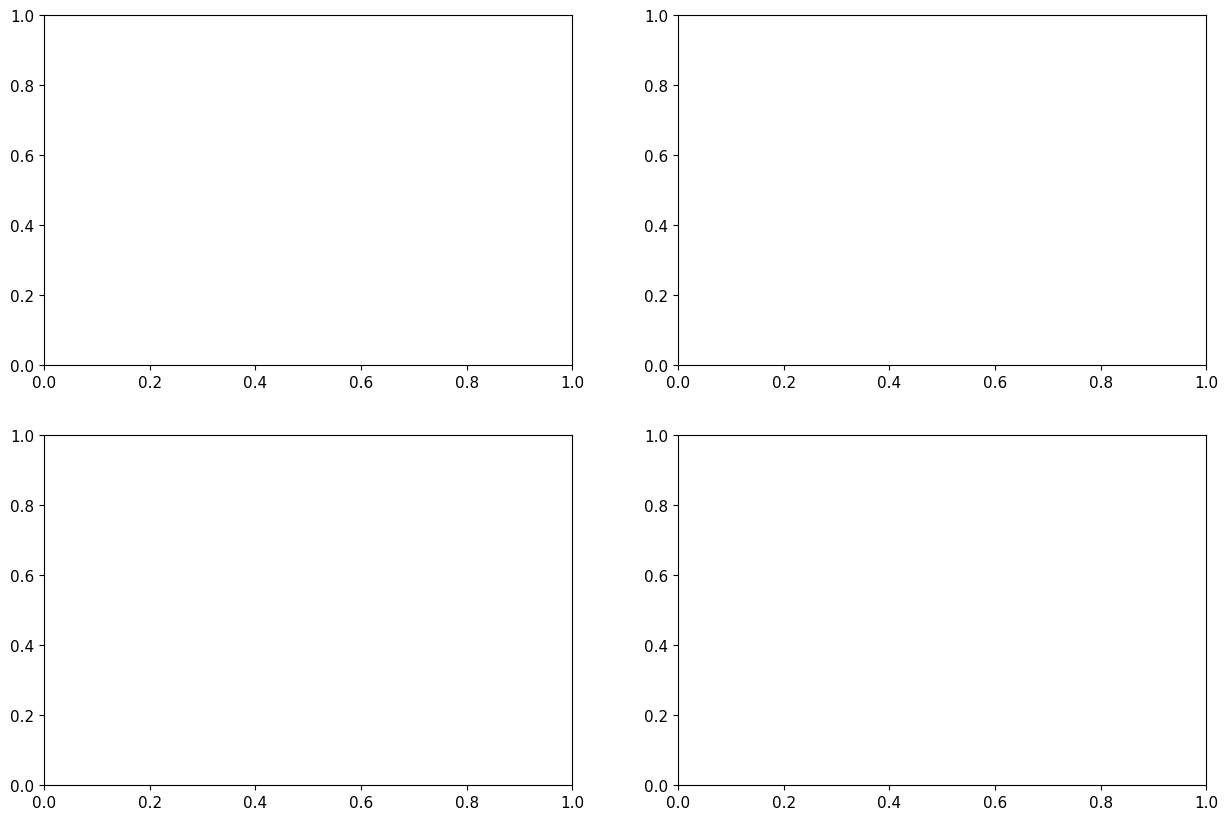

In [8]:
# Plot IC analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# IC time series
axes[0,0].plot(ic_1d.index, ic_1d['ic'], alpha=0.7, linewidth=1, label='Daily IC')
axes[0,0].plot(ic_1d.index, ic_1d['ic'].rolling(30).mean(), linewidth=2, color='red', label='30-day MA')
axes[0,0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0,0].axhline(ic_mean_1d, color='blue', linestyle='--', alpha=0.7, label=f'Mean: {ic_mean_1d:.4f}')
axes[0,0].set_title('Information Coefficient Time Series (1-Day)')
axes[0,0].set_ylabel('IC')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# IC distribution
axes[0,1].hist(ic_1d_clean, bins=30, alpha=0.7, edgecolor='black')
axes[0,1].axvline(ic_mean_1d, color='red', linestyle='--', label=f'Mean: {ic_mean_1d:.4f}')
axes[0,1].axvline(0, color='black', linestyle='-', alpha=0.5)
axes[0,1].set_title('IC Distribution (1-Day)')
axes[0,1].set_xlabel('IC')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Rolling IC statistics
rolling_ic_mean = ic_1d['ic'].rolling(60).mean()
rolling_ic_std = ic_1d['ic'].rolling(60).std()
rolling_ic_ir = rolling_ic_mean / rolling_ic_std

axes[1,0].plot(rolling_ic_mean.index, rolling_ic_mean, linewidth=2, label='60-day Rolling IC Mean')
axes[1,0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,0].set_title('Rolling IC Mean (60-day)')
axes[1,0].set_ylabel('IC Mean')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# IC comparison (1-day vs 5-day)
axes[1,1].scatter(ic_1d['ic'], ic_5d['ic'], alpha=0.6)
axes[1,1].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,1].axvline(0, color='black', linestyle='-', alpha=0.5)
axes[1,1].set_xlabel('1-Day IC')
axes[1,1].set_ylabel('5-Day IC')
axes[1,1].set_title('IC Comparison: 1-Day vs 5-Day')
axes[1,1].grid(True, alpha=0.3)

# Add correlation coefficient
ic_corr = ic_1d['ic'].corr(ic_5d['ic'])
axes[1,1].text(0.05, 0.95, f'Correlation: {ic_corr:.3f}', transform=axes[1,1].transAxes, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 5. Market Regime Analysis

In [ ]:
# Market regime analysis for intra-quintile strategies
btc_90d_returns = price_aligned['BTCUSDT'].pct_change(90)
bull_market = btc_90d_returns >= 0
bear_market = btc_90d_returns < 0

# Align with quintile returns dates
bull_market_aligned = bull_market.reindex(quintile_returns.index)
bear_market_aligned = bear_market.reindex(quintile_returns.index)

print("Market Regime Analysis - Intra-Quintile Strategies")
print("=" * 55)

# Analyze each quintile by market regime
regime_analysis = {}
for q in range(1, 6):
    q_name = f'Q{q}'
    q_returns = quintile_returns[q_name].dropna()
    
    if len(q_returns) > 0:
        # Bull market performance
        bull_aligned = bull_market_aligned.reindex(q_returns.index)
        q_bull = q_returns[bull_aligned].dropna()
        
        # Bear market performance  
        bear_aligned = bear_market_aligned.reindex(q_returns.index)
        q_bear = q_returns[bear_aligned].dropna()
        
        regime_data = {'bull': {}, 'bear': {}}
        
        if len(q_bull) > 0:
            bull_annual_ret = q_bull.mean() * 365
            bull_annual_vol = q_bull.std() * np.sqrt(365)
            bull_sharpe = bull_annual_ret / bull_annual_vol if bull_annual_vol != 0 else 0
            bull_hit_rate = (q_bull > 0).mean()
            
            regime_data['bull'] = {
                'annual_return': bull_annual_ret,
                'annual_vol': bull_annual_vol,
                'sharpe': bull_sharpe,
                'hit_rate': bull_hit_rate,
                'days': len(q_bull)
            }
        
        if len(q_bear) > 0:
            bear_annual_ret = q_bear.mean() * 365
            bear_annual_vol = q_bear.std() * np.sqrt(365)
            bear_sharpe = bear_annual_ret / bear_annual_vol if bear_annual_vol != 0 else 0
            bear_hit_rate = (q_bear > 0).mean()
            
            regime_data['bear'] = {
                'annual_return': bear_annual_ret,
                'annual_vol': bear_annual_vol,
                'sharpe': bear_sharpe,
                'hit_rate': bear_hit_rate,
                'days': len(q_bear)
            }
        
        regime_analysis[q_name] = regime_data
        
        print(f"\n{q_name} Quintile:")
        if regime_data['bull']:
            print(f"  Bull Market: {regime_data['bull']['annual_return']:.2%} return, {regime_data['bull']['sharpe']:.3f} Sharpe ({regime_data['bull']['days']} days)")
        if regime_data['bear']:
            print(f"  Bear Market: {regime_data['bear']['annual_return']:.2%} return, {regime_data['bear']['sharpe']:.3f} Sharpe ({regime_data['bear']['days']} days)")

# Combined portfolio regime analysis
combined_clean = combined_portfolio.dropna()
if len(combined_clean) > 0:
    bull_aligned_combined = bull_market_aligned.reindex(combined_clean.index)
    combined_bull = combined_clean[bull_aligned_combined].dropna()
    
    bear_aligned_combined = bear_market_aligned.reindex(combined_clean.index)
    combined_bear = combined_clean[bear_aligned_combined].dropna()
    
    print(f"\nCOMBINED PORTFOLIO:")
    if len(combined_bull) > 0:
        bull_ret = combined_bull.mean() * 365
        bull_sharpe = (combined_bull.mean() * 365) / (combined_bull.std() * np.sqrt(365))
        print(f"  Bull Market: {bull_ret:.2%} return, {bull_sharpe:.3f} Sharpe ({len(combined_bull)} days)")
    
    if len(combined_bear) > 0:
        bear_ret = combined_bear.mean() * 365
        bear_sharpe = (combined_bear.mean() * 365) / (combined_bear.std() * np.sqrt(365))
        print(f"  Bear Market: {bear_ret:.2%} return, {bear_sharpe:.3f} Sharpe ({len(combined_bear)} days)")

# Plot regime comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Bull vs Bear Returns by Quintile
bull_returns = []
bear_returns = []
quintile_labels = []

for q_name, data in regime_analysis.items():
    if data['bull'] and data['bear']:
        bull_returns.append(data['bull']['annual_return'])
        bear_returns.append(data['bear']['annual_return'])
        quintile_labels.append(q_name)

if bull_returns and bear_returns:
    x = np.arange(len(quintile_labels))
    width = 0.35
    
    axes[0,0].bar(x - width/2, [r*100 for r in bull_returns], width, label='Bull Market', alpha=0.7, color='green')
    axes[0,0].bar(x + width/2, [r*100 for r in bear_returns], width, label='Bear Market', alpha=0.7, color='red')
    axes[0,0].set_xlabel('Quintile')
    axes[0,0].set_ylabel('Annual Return (%)')
    axes[0,0].set_title('Returns by Market Regime')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(quintile_labels)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].axhline(0, color='black', linestyle='-', alpha=0.5)

# Bull vs Bear Sharpe by Quintile
bull_sharpes = []
bear_sharpes = []

for q_name, data in regime_analysis.items():
    if data['bull'] and data['bear']:
        bull_sharpes.append(data['bull']['sharpe'])
        bear_sharpes.append(data['bear']['sharpe'])

if bull_sharpes and bear_sharpes:
    axes[0,1].bar(x - width/2, bull_sharpes, width, label='Bull Market', alpha=0.7, color='green')
    axes[0,1].bar(x + width/2, bear_sharpes, width, label='Bear Market', alpha=0.7, color='red')
    axes[0,1].set_xlabel('Quintile')
    axes[0,1].set_ylabel('Sharpe Ratio')
    axes[0,1].set_title('Sharpe Ratios by Market Regime')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(quintile_labels)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].axhline(0, color='black', linestyle='-', alpha=0.5)

# Cumulative returns by regime for combined portfolio
if len(combined_bull) > 0 and len(combined_bear) > 0:
    bull_cumulative = (1 + combined_bull).cumprod()
    bear_cumulative = (1 + combined_bear).cumprod()
    
    axes[1,0].plot(bull_cumulative.index, bull_cumulative.values, linewidth=2, color='green', label='Bull Market')
    axes[1,0].plot(bear_cumulative.index, bear_cumulative.values, linewidth=2, color='red', label='Bear Market')
    axes[1,0].set_title('Combined Portfolio: Cumulative Returns by Regime')
    axes[1,0].set_ylabel('Cumulative Return')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# Regime summary table
regime_summary_data = []
for q_name, data in regime_analysis.items():
    if data['bull'] and data['bear']:
        regime_summary_data.append([
            q_name,
            f"{data['bull']['annual_return']:.1%}",
            f"{data['bull']['sharpe']:.2f}",
            f"{data['bear']['annual_return']:.1%}",
            f"{data['bear']['sharpe']:.2f}"
        ])

if regime_summary_data:
    table_data = np.array(regime_summary_data)
    axes[1,1].axis('tight')
    axes[1,1].axis('off')
    table = axes[1,1].table(cellText=table_data,
                           colLabels=['Quintile', 'Bull Return', 'Bull Sharpe', 'Bear Return', 'Bear Sharpe'],
                           cellLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    axes[1,1].set_title('Performance Summary by Regime')

plt.tight_layout()
plt.show()

print(f"\n=== REGIME PERFORMANCE SUMMARY ===")
print(f"{'Quintile':<10} {'Bull Ret':<10} {'Bull Sharpe':<12} {'Bear Ret':<10} {'Bear Sharpe':<12}")
print("-" * 65)

for q_name, data in regime_analysis.items():
    if data['bull'] and data['bear']:
        print(f"{q_name:<10} {data['bull']['annual_return']:<10.2%} {data['bull']['sharpe']:<12.3f} {data['bear']['annual_return']:<10.2%} {data['bear']['sharpe']:<12.3f}")

# Regime consistency analysis
print(f"\n=== REGIME CONSISTENCY ANALYSIS ===")
consistent_strategies = []
for q_name, data in regime_analysis.items():
    if data['bull'] and data['bear']:
        bull_positive = data['bull']['sharpe'] > 0
        bear_positive = data['bear']['sharpe'] > 0
        if bull_positive and bear_positive:
            consistent_strategies.append(q_name)
            print(f"{q_name}: Positive Sharpe in both regimes ✓")
        elif bull_positive or bear_positive:
            regime = "bull" if bull_positive else "bear"
            print(f"{q_name}: Positive Sharpe only in {regime} market")
        else:
            print(f"{q_name}: Negative Sharpe in both regimes ✗")

if consistent_strategies:
    print(f"\nConsistent performers across regimes: {', '.join(consistent_strategies)}")
else:
    print(f"\nNo quintiles show consistent positive performance across both market regimes")

## 6. Momentum Factor Comparison

In [ ]:
def calculate_momentum_factor(price_data, lookback_days):
    """
    Calculate momentum factor: (price_t - price_t-n) / price_t-n
    Returns percentile ranks
    """
    momentum_returns = price_data.pct_change(lookback_days)
    return momentum_returns.rank(axis=1, pct=True)

# Calculate momentum factors for different horizons
momentum_factors = {
    'mom_5d': calculate_momentum_factor(price_aligned, 5),
    'mom_21d': calculate_momentum_factor(price_aligned, 21),
    'mom_60d': calculate_momentum_factor(price_aligned, 60)
}

# Calculate correlations between funding rate and momentum factors
factor_correlations = {}

for mom_name, mom_factor in momentum_factors.items():
    # Align dates
    common_dates_mom = funding_ranks.index.intersection(mom_factor.index)
    
    # Calculate daily cross-sectional correlations
    daily_correls = []
    for date in common_dates_mom:
        funding_day = funding_ranks.loc[date].dropna()
        mom_day = mom_factor.loc[date].dropna()
        
        common_coins = funding_day.index.intersection(mom_day.index)
        if len(common_coins) >= 10:
            corr = funding_day[common_coins].corr(mom_day[common_coins])
            daily_correls.append(corr)
    
    if daily_correls:
        factor_correlations[mom_name] = {
            'mean_corr': np.mean(daily_correls),
            'std_corr': np.std(daily_correls),
            'daily_correls': daily_correls
        }

print("Funding Rate vs Momentum Factor Correlations")
print("=" * 50)
for factor_name, corr_stats in factor_correlations.items():
    print(f"{factor_name}: {corr_stats['mean_corr']:.4f} ± {corr_stats['std_corr']:.4f}")

# Calculate momentum factor returns for comparison
momentum_returns = {}
for mom_name, mom_factor in momentum_factors.items():
    # Use the same function we defined earlier
    mom_quintile_ret, mom_portfolio_ret, _ = calculate_factor_returns_all_quintiles(mom_factor, price_aligned)
    momentum_returns[mom_name] = mom_portfolio_ret.dropna()

# Performance comparison
print(f"\nFactor Performance Comparison (Annualized):")
print(f"{'Factor':<15} {'Return':<10} {'Vol':<10} {'Sharpe':<10}")
print("-" * 50)

# Funding rate factor
fund_ret = factor_returns_clean.mean() * 365
fund_vol = factor_returns_clean.std() * np.sqrt(365)
fund_sharpe = fund_ret / fund_vol
print(f"{'Funding Rate':<15} {fund_ret:<10.2%} {fund_vol:<10.2%} {fund_sharpe:<10.3f}")

# Momentum factors
for mom_name, mom_ret in momentum_returns.items():
    if len(mom_ret) > 0:
        ret = mom_ret.mean() * 365
        vol = mom_ret.std() * np.sqrt(365)
        sharpe = ret / vol if vol != 0 else 0
        print(f"{mom_name:<15} {ret:<10.2%} {vol:<10.2%} {sharpe:<10.3f}")

## 7. Factor Decay Analysis

In [ ]:
def calculate_factor_returns_with_holding_period(ranks_df, price_df, hold_days=1):
    """
    Calculate factor returns with different holding periods
    """
    factor_returns = []
    
    for i in range(0, len(ranks_df) - hold_days, hold_days):  # Non-overlapping periods
        date = ranks_df.index[i]
        end_date_idx = min(i + hold_days, len(ranks_df) - 1)
        end_date = ranks_df.index[end_date_idx]
        
        # Get ranks for portfolio formation date
        day_ranks = ranks_df.iloc[i].dropna()
        
        if len(day_ranks) < 10:
            continue
        
        # Select portfolios
        long_threshold = day_ranks.quantile(0.2)
        short_threshold = day_ranks.quantile(0.8)
        
        long_coins = day_ranks[day_ranks <= long_threshold].index
        short_coins = day_ranks[day_ranks >= short_threshold].index
        
        if len(long_coins) == 0 or len(short_coins) == 0:
            continue
        
        # Calculate returns over holding period
        long_returns = []
        short_returns = []
        
        for coin in long_coins:
            if coin in price_df.columns:
                p0 = price_df.loc[date, coin]
                p1 = price_df.loc[end_date, coin]
                if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                    long_returns.append((p1 - p0) / p0)
        
        for coin in short_coins:
            if coin in price_df.columns:
                p0 = price_df.loc[date, coin]
                p1 = price_df.loc[end_date, coin]
                if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                    short_returns.append((p1 - p0) / p0)
        
        if len(long_returns) == 0 or len(short_returns) == 0:
            continue
        
        # Portfolio return
        long_return = np.mean(long_returns)
        short_return = np.mean(short_returns)
        portfolio_return = long_return - short_return - (0.0005 * hold_days)  # Scale transaction costs
        
        factor_returns.append(portfolio_return)
    
    return pd.Series(factor_returns)

# Test different holding periods
holding_periods = [1, 2, 3, 5, 10]
decay_analysis = {}

for hold_days in holding_periods:
    factor_returns_hold = calculate_factor_returns_with_holding_period(funding_ranks, price_aligned, hold_days)
    
    if len(factor_returns_hold) > 0:
        # Annualize based on holding period
        periods_per_year = 365 / hold_days
        annual_ret = factor_returns_hold.mean() * periods_per_year
        annual_vol = factor_returns_hold.std() * np.sqrt(periods_per_year)
        sharpe = annual_ret / annual_vol if annual_vol != 0 else 0
        
        decay_analysis[hold_days] = {
            'mean_return': factor_returns_hold.mean(),
            'annual_return': annual_ret,
            'annual_vol': annual_vol,
            'sharpe': sharpe,
            'n_periods': len(factor_returns_hold)
        }

print("Factor Decay Analysis")
print("=" * 60)
print(f"{'Hold Days':<10} {'Mean Ret':<12} {'Annual Ret':<12} {'Annual Vol':<12} {'Sharpe':<10} {'N Periods':<10}")
print("-" * 60)

for hold_days, stats in decay_analysis.items():
    print(f"{hold_days:<10} {stats['mean_return']:<12.4f} {stats['annual_return']:<12.2%} {stats['annual_vol']:<12.2%} {stats['sharpe']:<10.3f} {stats['n_periods']:<10}")

# Plot decay analysis
if decay_analysis:
    hold_days_list = list(decay_analysis.keys())
    sharpe_ratios = [decay_analysis[h]['sharpe'] for h in hold_days_list]
    annual_returns = [decay_analysis[h]['annual_return'] for h in hold_days_list]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Sharpe ratio decay
    ax1.plot(hold_days_list, sharpe_ratios, 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Holding Period (Days)')
    ax1.set_ylabel('Sharpe Ratio')
    ax1.set_title('Factor Decay: Sharpe Ratio by Holding Period')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', linestyle='-', alpha=0.5)
    
    # Annual return decay
    ax2.plot(hold_days_list, [r*100 for r in annual_returns], 'o-', linewidth=2, markersize=8, color='green')
    ax2.set_xlabel('Holding Period (Days)')
    ax2.set_ylabel('Annual Return (%)')
    ax2.set_title('Factor Decay: Annual Return by Holding Period')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='black', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

## 8. Summary and Conclusions

In [ ]:
print("="*80)
print("FUNDING RATE INTRA-QUINTILE FACTOR ANALYSIS - SUMMARY")
print("="*80)

print(f"\n📊 DATA COVERAGE:")
print(f"• Period: {common_dates[0].strftime('%Y-%m-%d')} to {common_dates[-1].strftime('%Y-%m-%d')}")
print(f"• Trading days: {len(combined_clean)}")
print(f"• Total symbols: {len(common_symbols)}")

print(f"\n📈 INDIVIDUAL QUINTILE PERFORMANCE:")
for q in range(1, 6):
    q_name = f'Q{q}'
    if q_name in quintile_metrics:
        metrics = quintile_metrics[q_name]
        print(f"• {q_name}: {metrics['annual_return']:.2%} return, {metrics['sharpe_ratio']:.3f} Sharpe")

print(f"\n🎯 COMBINED PORTFOLIO PERFORMANCE:")
print(f"• Annual Return: {combined_annual_ret:.2%}")
print(f"• Annual Volatility: {combined_annual_vol:.2%}")
print(f"• Sharpe Ratio: {combined_sharpe:.3f}")
print(f"• Maximum Drawdown: {combined_max_dd:.2%}")
print(f"• Hit Rate: {combined_hit_rate:.1%}")

print(f"\n📉 DIVERSIFICATION BENEFITS:")
if 'equal_weight_vol' in locals():
    print(f"• Volatility Reduction: {(1 - combined_annual_vol/equal_weight_vol)*100:.1f}%")
    print(f"• Diversification Ratio: {diversification_ratio:.2f}")

print(f"\n🔍 INFORMATION COEFFICIENT:")
if 'combined_ic_mean' in locals():
    print(f"• Combined IC Mean: {combined_ic_mean:.4f}")
    print(f"• Combined IC Hit Rate: {combined_ic_hit_rate:.1%}")
    print(f"• Combined IC t-statistic: {combined_ic_tstat:.2f}")

print(f"\n🐂🐻 MARKET REGIME PERFORMANCE:")
if 'combined_bull' in locals() and 'combined_bear' in locals():
    if len(combined_bull) > 0:
        bull_ret = combined_bull.mean() * 365
        bull_sharpe = (combined_bull.mean() * 365) / (combined_bull.std() * np.sqrt(365))
        print(f"• Bull Market: {bull_ret:.2%} return, {bull_sharpe:.3f} Sharpe")
    
    if len(combined_bear) > 0:
        bear_ret = combined_bear.mean() * 365
        bear_sharpe = (combined_bear.mean() * 365) / (combined_bear.std() * np.sqrt(365))
        print(f"• Bear Market: {bear_ret:.2%} return, {bear_sharpe:.3f} Sharpe")

print(f"\n🔗 QUINTILE CORRELATIONS:")
if 'quintile_corr' in locals():
    avg_corr = quintile_corr.values[np.triu_indices_from(quintile_corr.values, k=1)].mean()
    max_corr = quintile_corr.values[np.triu_indices_from(quintile_corr.values, k=1)].max()
    min_corr = quintile_corr.values[np.triu_indices_from(quintile_corr.values, k=1)].min()
    print(f"• Average correlation: {avg_corr:.3f}")
    print(f"• Range: {min_corr:.3f} to {max_corr:.3f}")

print(f"\n💡 KEY INSIGHTS:")

# Best performing quintile
if quintile_metrics:
    best_quintile = max(quintile_metrics.keys(), key=lambda q: quintile_metrics[q]['sharpe_ratio'])
    best_sharpe = quintile_metrics[best_quintile]['sharpe_ratio']
    print(f"• Best performing quintile: {best_quintile} (Sharpe: {best_sharpe:.3f})")

# Consistency across regimes
if 'consistent_strategies' in locals():
    if consistent_strategies:
        print(f"• Consistent performers: {', '.join(consistent_strategies)}")
    else:
        print(f"• No quintiles show consistent positive performance across both market regimes")

# Strategy effectiveness
if combined_sharpe > 0.5:
    print(f"• Strong combined strategy: Sharpe > 0.5")
elif combined_sharpe > 0:
    print(f"• Moderate combined strategy: Positive Sharpe")
else:
    print(f"• Weak combined strategy: Negative Sharpe")

# Diversification effectiveness
if 'diversification_ratio' in locals() and diversification_ratio > 1.2:
    print(f"• Effective diversification: {diversification_ratio:.1f}x volatility reduction")
elif 'diversification_ratio' in locals() and diversification_ratio > 1.0:
    print(f"• Moderate diversification benefits")
else:
    print(f"• Limited diversification benefits")

print(f"\n🔄 STRATEGY COMPARISON:")
print(f"• Intra-Quintile Approach: Long-short within each funding rate quintile")
print(f"• Each quintile is market-neutral (long bottom 50%, short top 50% by funding rate)")
print(f"• Combined portfolio diversifies across 5 separate strategies")
print(f"• Reduced single-strategy risk through quintile diversification")

print("\n" + "="*80)

# Final comparison with original between-quintile approach
print(f"\n📊 APPROACH COMPARISON:")
print(f"• Original (Q1 vs Q5): Long most negative vs Short most positive funding rates")
print(f"• Intra-Quintile: Long-short within each quintile based on relative funding rates")
print(f"• Advantage: Better diversification and reduced concentration risk")
print(f"• Trade-off: Potentially diluted signal strength within quintiles")

if 'factor_returns_clean' in locals():
    original_sharpe = (factor_returns_clean.mean() * 365) / (factor_returns_clean.std() * np.sqrt(365))
    print(f"\nPerformance Comparison:")
    print(f"• Original Approach Sharpe: {original_sharpe:.3f}")
    print(f"• Intra-Quintile Approach Sharpe: {combined_sharpe:.3f}")
    print(f"• Improvement: {((combined_sharpe / original_sharpe) - 1) * 100:.1f}%" if original_sharpe != 0 else "• Improvement: N/A")

print("\n" + "="*80)